# Problem statement: 
* The data has 9303 rows and 7 variables. Dataset is imbalanced: 3496 Delayed vs. 5807 On-time. 
* This is a binary classification problem. The classification goal is to predict whether a given flight has delay or not.


# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the missing values, etc.)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicated values, etc. 
- Basic data exploration
- Preparing data for Machine Learning:
    - One-hot-encoding of categorical features
    - Vector Assembling
    - Splitting data into training & test parts (I use the training part for training & hyperparameter tuning of models, test part for the final evaluation of models)
    
 # Model Training: 
- I separately train following models:
     - Logistic Regression (LR)
     - Random Forest (RF)
     - Gradient Boosting Trees (GBTs)
     
 Note: I use Grid-Search technique to find optimal hyper-parameters of each model. Also, I undersample the majority-class data points to even the imbalances. 

  # Model Evaluation: 
- I separately evaluate the best LR, RF and GBT models, by calculating/plotting following mertics on Test dataset:
     - roc_auc score
     - f1 score
     - Confusion matrix
     - ROC curve  
     - Average precision
 
 
- Calculating the Feature Importance with RF and GBTs models.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import findspark 
findspark.init('/home/rhashemee/spark-2.1.0-bin-hadoop2.7')

import pyspark

import sklearn
import numpy as np
import pandas as pd
import imblearn as im
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]")\
                            .appName("Flight_Delay")\
                            .enableHiveSupport()\
                            .getOrCreate()

#spark.conf.set('spark.driver.memory','8g')
#spark.conf.set('spark.executor.memory', '8g')
#spark.conf.set('spark.executor.cores', '6')
#spark.conf.set('spark.cores.max', '6')

sc = spark.sparkContext

In [4]:
# helpful function to detect the Missing Values:
def detect_missing(df):
    import pyspark.sql.functions as fn
    miss_count=df.agg(*[(fn.count('*')-fn.count(c)).alias(c)   for c in df.columns]).toPandas()
    miss_percent=df.agg(*[(1-(fn.count(c)/fn.count('*'))).alias(c)   for c in df.columns]).toPandas()
    
    summary = pd.concat([miss_count, miss_percent], axis=0)
    summary['  '] = ['Count of miss values: ', 'Percentage of miss values: ']
    summary.set_index('  ', inplace=True)
    return summary

In [5]:
df_flights=spark.read.csv('flights_small.csv', header=True, inferSchema=True)
df_airports=spark.read.csv('airports.csv', header=True, inferSchema=True)
df_planes=spark.read.csv('planes.csv', header=True, inferSchema=True)

In [6]:
# Rename the columne name 'year' in 'plane' df:
df_planes=df_planes.withColumnRenamed('year', 'manufact_year')

In [7]:
# Join the 'flights' and 'planes' datasets, on 'tailnum':
df = df_flights.join(df_planes, on='tailnum', how='leftouter')

In [8]:
# Convert appropriate columns of df to 'integer' type:
for c in ['dep_time', 'dep_delay', 'arr_time', 'arr_delay', 'air_time', 'hour', 'minute', 'manufact_year', 'speed']:
    df= df.withColumn(c, df[c].cast('integer'))

In [9]:
# build a new columne for "plane_age":
df=df.withColumn('plane_age', (df.year)-(df.manufact_year))

In [10]:
# create the "label":
df=df.withColumn('is_late', df['arr_delay']>0)
df=df.withColumn('is_lateIndex', df['is_late'].cast('integer'))

In [11]:
df = df.repartition(4)

In [12]:
df.printSchema()

root
 |-- tailnum: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dep_time: integer (nullable = true)
 |-- dep_delay: integer (nullable = true)
 |-- arr_time: integer (nullable = true)
 |-- arr_delay: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- air_time: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- manufact_year: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- engines: integer (nullable = true)
 |-- seats: integer (nullable = true)
 |-- speed: integer (nullable = true)
 |-- engine: string (nullable = true)
 |-- plane_age: integer (nullable = true)
 |-- is_la

In [13]:
# select label + informative features:
df=df.select('plane_age', 'air_time', 'month', 'carrier', 'dest', 'origin', 'is_lateIndex')

In [14]:
detect_missing(df)

,plane_age,air_time,month,carrier,dest,origin,is_lateIndex
,,,,,,,
Count of miss values:,646.0000,75.0000,0.0,0.0,0.0,0.0,75.0000
Percentage of miss values:,0.0646,0.0075,0.0,0.0,0.0,0.0,0.0075


In [15]:
# Drop all missing values:
df=df.na.drop(subset=['plane_age', 'air_time', 'is_lateIndex'])

In [16]:
detect_missing(df)

,plane_age,air_time,month,carrier,dest,origin,is_lateIndex
,,,,,,,
Count of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df.count()

9303

In [18]:
df.groupBy('is_lateIndex').count().show()

+------------+-----+
|is_lateIndex|count|
+------------+-----+
|           1| 3496|
|           0| 5807|
+------------+-----+



# Preparing Data for Machine Learning:

In [18]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# One-Hot-Encoding of Categorical features:
categoricalColumns = ['carrier', 'dest', 'origin']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "_classVec")
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'is_lateIndex', outputCol = 'label')

stages += [label_stringIdx]

# Continuous features: 
numericCols = ['plane_age', 'air_time', 'month']

# Vector assembling:
assemblerInputs = [c + "_classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [19]:
# Pipeline: ___________________________________
from pyspark.ml import Pipeline

cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_piped = pipelineModel.transform(df)

selectedCols = ['label', 'features'] + cols
df_piped = df_piped.select(selectedCols)
df_piped.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- plane_age: integer (nullable = true)
 |-- air_time: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- is_lateIndex: integer (nullable = true)



In [20]:
train, test = df_piped.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 6482
Test Dataset Count: 2821


# 1) Logistic Regression Model: 

In [21]:
# To calculate the Calss Weight for Logestic Regression:
new_train=train.join(train.groupBy('label').count(), 'label', how='leftouter')
train_weight=new_train.withColumn('weight', train.count()/(new_train['count']))

train_weight.groupBy('weight').count().show()

+-----------------+-----+
|           weight|count|
+-----------------+-----+
|1.618881118881119| 4004|
|2.615819209039548| 2478|
+-----------------+-----+



In [22]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, 
                         weightCol ='weight')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(lr.regParam, [0, 0.001, 10])
grid=grid.addGrid(lr.elasticNetParam, [0, 0.05, 0.1, 0.2])
grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=lr,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [23]:
# fit the model:
models=cv.fit(train_weight)
best_lr=models.bestModel

# Best hyper-parameters: 
java_model = best_lr._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})
print("Best cross-validation score:  ", round(max(models.avgMetrics), 2)) 

Best hyper-parameters:  {'regParam': 0.0, 'elasticNetParam': 0.0}
Best cross-validation score:   0.66


In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
print('Test roc_auc score: ', round(best_lr.evaluate(test).areaUnderROC,2), '\n')

print('Test average precision: ', round(evaluator.evaluate(best_lr.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Test f1 score: ', round(my_eval.evaluate(best_lr.transform(test)),2))

Test roc_auc score:  0.64 

Test average precision:  0.5 

Test f1 score:  0.62


In [25]:
# Prediction on test dataset:
test_predictions = best_lr.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[-0.1880666743327...|[0.45312142102971...|       1.0|
|  0.0|[-0.2677801827107...|[0.43345213789439...|       1.0|
|  0.0|[-0.7290283274749...|[0.32540799047166...|       1.0|
|  0.0|[-0.4821736735766...|[0.38173897540909...|       1.0|
|  0.0|[-0.5402735426843...|[0.36812395155856...|       1.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[1109  694]
 [ 399  619]]
Normalized confusion matrix
[[0.62 0.38]
 [0.39 0.61]]


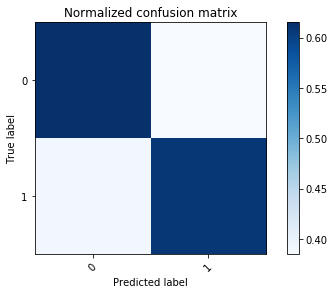

In [26]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

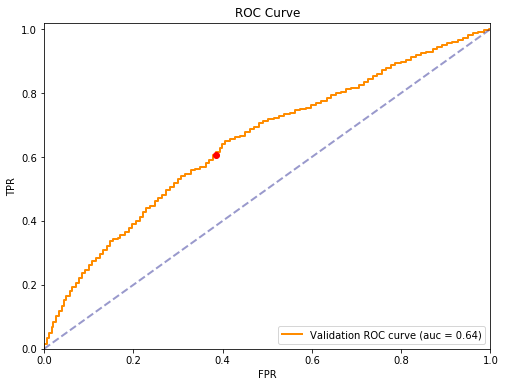

In [27]:
# ROC curve:______________________________________
validation_accuracy=best_lr.evaluate(test)
roc=validation_accuracy.roc.toPandas()
roc_auc=validation_accuracy.areaUnderROC

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(roc['FPR'],roc['TPR'], color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")

recall=validation_accuracy.recallByThreshold.toPandas()
recall=recall[np.round(recall['threshold'], 2)==0.5]['recall']
roc=validation_accuracy.roc.toPandas().iloc[recall.index[0]+1]
plt.plot(roc[0], roc[1], 'or')

plt.show()

# 2) Random Forest Model: 

In [29]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(rf.maxDepth, [30])
grid=grid.addGrid(rf.numTrees, [80])
grid=grid.addGrid(rf.maxBins, [32, 48])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=rf,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [30]:
# fit the model:
models=cv.fit(train)
best_rf=models.bestModel

# Best hyper-parameters: 
java_model = best_rf._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})
print("Best cross-validation score:  ", round(max(models.avgMetrics), 2)) 

Best hyper-parameters:  {'maxBins': 48, 'numTrees': 80, 'maxDepth': 30}
Best cross-validation score:   0.64


In [31]:
my_eval= BinaryClassificationEvaluator(metricName='areaUnderROC')
print('Test roc_auc score: ', round(my_eval.evaluate(best_rf.transform(test)),2), '\n')

print('Test average precision: ', round(evaluator.evaluate(best_rf.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Test f1 score: ', round(my_eval.evaluate(best_rf.transform(test)),2))

Test roc_auc score:  0.67 

Test average precision:  0.53 

Test f1 score:  0.62


In [32]:
# Prediction on test dataset:
test_predictions = best_rf.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[53.0127421948454...|[0.66265927743556...|       0.0|
|  0.0|[48.9755327145514...|[0.61219415893189...|       0.0|
|  0.0|[44.1223243236715...|[0.55152905404589...|       0.0|
|  0.0|[51.8196565003470...|[0.64774570625433...|       0.0|
|  0.0|[43.9022766284530...|[0.54877845785566...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[1644  159]
 [ 783  235]]
Normalized confusion matrix
[[0.91 0.09]
 [0.77 0.23]]


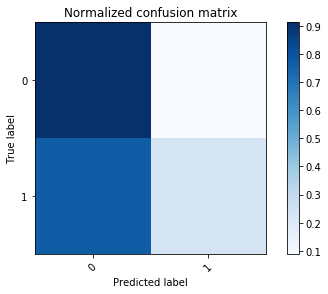

In [33]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

# Undersampling the majority class to balance the dataset for RF model:
    - Note: RF model doesn't get the "weightCol" parameter for the imbalanced dataset.
            So, we need to Undersample the majority class to improve Recall & Precision for minority class.

In [34]:
# Undersmapling the majority class:
ratio = train.filter(train['is_lateIndex']==1).count() / train.filter(train['is_lateIndex']==0).count()

undersampled_train = train.sampleBy('is_lateIndex', fractions={0: ratio, 1: 1.0}, seed=42)

undersampled_train.groupby('is_lateIndex').count().show()

+------------+-----+
|is_lateIndex|count|
+------------+-----+
|           1| 2478|
|           0| 2451|
+------------+-----+



In [35]:
# fit the model on train dataset with Undersampled majority class:
models=cv.fit(undersampled_train)
best_rf=models.bestModel

# Best hyper-parameters: 
java_model = best_rf._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})
print("Best cross-validation score:  ", round(max(models.avgMetrics), 2)) 

Best hyper-parameters:  {'maxBins': 48, 'numTrees': 80, 'maxDepth': 30}
Best cross-validation score:   0.64


In [36]:
my_eval= BinaryClassificationEvaluator(metricName='areaUnderROC')
print('Test roc_auc score: ', round(my_eval.evaluate(best_rf.transform(test)),2), '\n')

print('Test average precision: ', round(evaluator.evaluate(best_rf.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Test f1 score: ', round(my_eval.evaluate(best_rf.transform(test)),2))

Test roc_auc score:  0.66 

Test average precision:  0.5 

Test f1 score:  0.63


In [37]:
# Prediction on test dataset:
test_predictions = best_rf.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[42.1453364864161...|[0.52681670608020...|       0.0|
|  0.0|[42.5995456717694...|[0.53249432089711...|       0.0|
|  0.0|[33.3781483454742...|[0.41722685431842...|       1.0|
|  0.0|[49.4018698321290...|[0.61752337290161...|       0.0|
|  0.0|[37.3446918151348...|[0.46680864768918...|       1.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[1126  677]
 [ 378  640]]
Normalized confusion matrix
[[0.62 0.38]
 [0.37 0.63]]


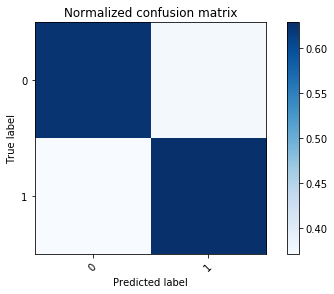

In [38]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

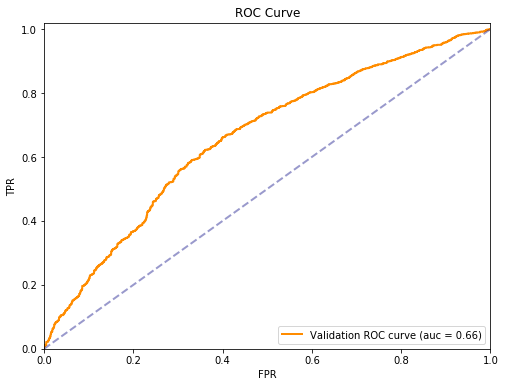

In [39]:
# ROC curve:______________________________________
prediction = best_rf.transform(test)
results= prediction.select(['probability', 'label']).collect()
results = [(i[0][0], 1.0-i[1]) for i in results]

from sklearn.metrics import roc_curve, auc
 
fpr= dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results]
y_score = [i[0] for i in results]
 
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(fpr, tpr, color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")


plt.show()

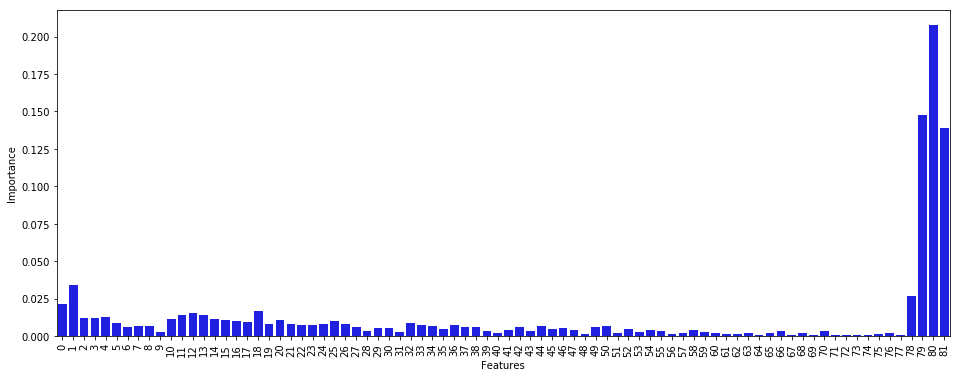

In [40]:
# Feature Importance: 
im=best_rf.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=90)
plt.show()

# 3) Gradient-Boosted Trees:

In [41]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.MulticlassClassificationEvaluator(metricName='f1')

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(gb.maxDepth, [4, 6])
grid=grid.addGrid(gb.maxIter, [128])
grid=grid.addGrid(gb.maxBins, [16, 48])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=gb,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [42]:
# fit the model:
models=cv.fit(train)
best_gb=models.bestModel

# Best hyper-parameters: 
java_model = best_gb._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})
print("Best cross-validation score:  ", round(max(models.avgMetrics), 2)) 

Best hyper-parameters:  {'maxBins': 48, 'maxDepth': 4, 'maxIter': 128}
Best cross-validation score:   0.63


In [43]:
print("Test f1 score:  ", round(evaluator.evaluate(best_gb.transform(test)),2))

Test f1 score:   0.65


In [44]:
# Prediction on test dataset:
test_predictions = best_gb.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[1567  236]
 [ 667  351]]
Normalized confusion matrix
[[0.87 0.13]
 [0.66 0.34]]


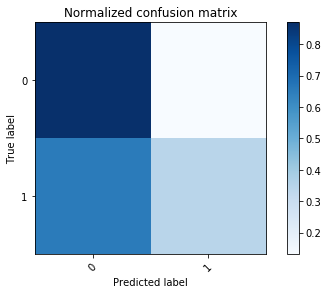

In [45]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

#  Undersampling the majority class to balance the dataset for GBT model:
    - Note: Gradient-Boosted Trees model doesn't get the "weightCol" parameter for the imbalanced dataset.
            So, we need to Undersample the majority class to improve Recall & Precision for minority class.

In [46]:
# fit the model on train dataset with Undersampled majority class:
models=cv.fit(undersampled_train)
best_gb=models.bestModel

# Best hyper-parameters: 
java_model = best_gb._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})
print("Best cross-validation score:  ", round(max(models.avgMetrics), 2)) 

Best hyper-parameters:  {'maxBins': 48, 'maxDepth': 4, 'maxIter': 128}
Best cross-validation score:   0.62


In [47]:
print("Test f1 score:  ", round(evaluator.evaluate(best_gb.transform(test)),2))

Test f1 score:   0.64


In [48]:
# Prediction on test dataset:
test_predictions = best_gb.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
+-----+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[1186  617]
 [ 401  617]]
Normalized confusion matrix
[[0.66 0.34]
 [0.39 0.61]]


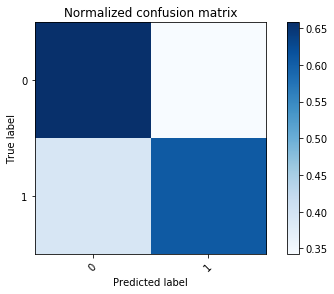

In [49]:
# Plot a confusion matrix:   
# Compute confusion matrix:
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

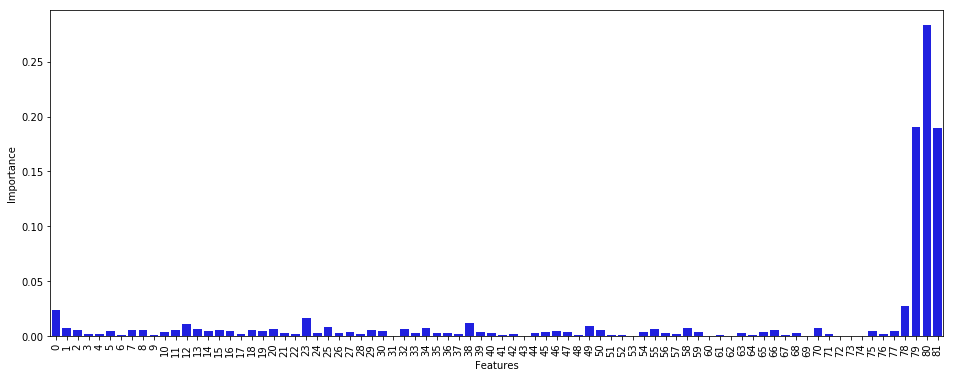

In [50]:
# Feature Importance: 
im=best_gb.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=90)

plt.show()

In [51]:
sc.stop()